# Homework_2022_04_14

<font color=ff0000> 截止日期 4.18 中午 11:59</font>


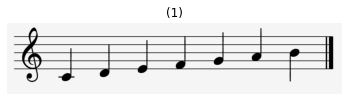

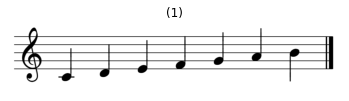

In [1]:
import matplotlib.pyplot as plt # plt 用于显示图片
import cv2 as cv # mpimg 用于读取图片
import numpy as np
from skimage.color import rgb2gray

def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
img = cv.imread('notation.png')
original = img.copy()
gray = rgb2gray(img)
show_images([img])
show_images([gray])

## 1.1 对灰度图像做直方图均衡，然后用otsu阈值二值化，请自己实现histogram_equalization。

[[246 246 246 ... 246 246 246]
 [246 246 246 ... 246 246 246]
 [246 246 246 ... 246 246 246]
 ...
 [246 246 246 ... 246 246 246]
 [246 246 246 ... 246 246 246]
 [246 246 246 ... 246 246 246]]


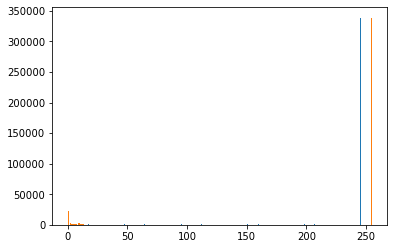

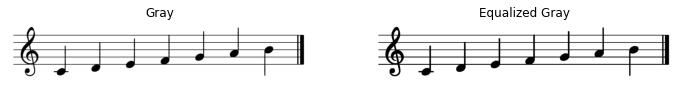

In [28]:
# TODO TODO TODO

def histogram_equalization(image):
    img_new = np.round(image*256).astype(np.uint8)
    print(img_new)
    hist = cv.calcHist([img_new], [0], None, [256], [0,256])
    plt.hist(range(256), weights=hist, bins=256)
    img_he = cv.equalizeHist(img_new)
    hist_he = cv.calcHist([img_he], [0], None, [256], [0,256])
    plt.hist(range(256), weights=hist_he, bins=256)
    return img_he

equalized_gray = histogram_equalization(gray)
show_images([gray, equalized_gray], ['Gray', 'Equalized Gray'])


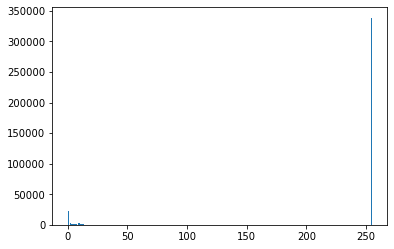

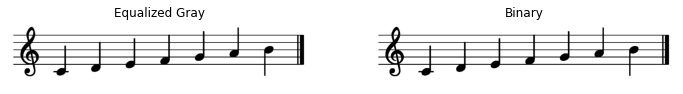

In [129]:
# TODO TODO TODO
blur = cv.GaussianBlur(equalized_gray, ksize=(1, 1), sigmaX=0, sigmaY=0)
blur = (blur*256).astype(np.uint16)
thresh, bin_img = cv.threshold(src=blur, thresh=0, maxval=255, type=cv.THRESH_BINARY+cv.THRESH_OTSU)
hist_blur = cv.calcHist([blur], [0], None, [256], [0,256])
plt.hist(range(256), weights=hist_blur, bins=256)

show_images([equalized_gray, bin_img], ['Equalized Gray', 'Binary'])


## 1.2 去掉谱子中的线。

In [130]:
def rle_encode(arr):
    x = np.copy(arr)
    first_dismatch = np.array(x[1:] != x[:-1])
    distmatch_positions = np.append(np.where(first_dismatch), len(x)-1)
    rle = np.diff(np.append(-1, distmatch_positions))
    values = [x[i] for i in np.cumsum(np.append(0, rle))[:-1]]
    return rle, values

def hv_rle(img, axis=1):
    # 可以理解为将 AACCCBBBBBAAAAFFFFFFFF 表示 A2C3B5A4F8
    # 对于黑白图像，可以方便的表示黑白间隔的长度
    rle, values = [], []

    if axis == 1:
        for i in range(img.shape[1]):
            col_rle, col_values = rle_encode(img[:, i])
            rle.append(col_rle)
            values.append(col_values)
    else:
        for i in range(img.shape[0]):
            row_rle, row_values = rle_encode(img[i])
            rle.append(row_rle)
            values.append(row_values)

    return rle, values

def calculate_pair_sum(arr):
    if len(arr) == 1:
        return list(arr)
    else:
        res = [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
        if len(arr) % 2 == 1:
            res.append(arr[-2] + arr[-1])
        return res
    
def get_most_common(rle):
    pair_sum = [calculate_pair_sum(col) for col in rle]

    flattened = []
    for col in pair_sum:
        flattened += col

    most_common = np.argmax(np.bincount(flattened))
    return most_common

rle, vals = hv_rle(bin_img)
# 根据rle黑白间隔的长，计算二值图像每行中黑色和白色的和，并找出最普遍的结果
# 可以认为这个最普遍的结果是五线谱的线间距
most_common = get_most_common(rle)
print(most_common)

32


In [131]:
# 已经计算出五线谱的线间距之后，统计黑白部分各占多少
from collections import Counter

def most_common_bw_pattern(arr, most_common):
    if len(arr) == 1:
        return []
    else:
        res = [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2)
               if arr[i] + arr[i + 1] == most_common]

        if len(arr) % 2 == 1 and arr[-2] + arr[-1] == most_common:
            res.append((arr[-2], arr[-1]))
        return res
    
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing

thickness, spacing = calculate_thickness_spacing(rle, most_common)
# 分别指黑色部分和白色部分
print(thickness, spacing)

3 29


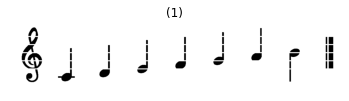

In [199]:
# TODO TODO TODO
# 用一个只包含线的滑窗去对齐原图（前后稍微移动取得卷积最大）后做减法。
# 然后再用膨胀~腐蚀（闭操作）对图像加工一下。
# 只去掉线的话会出现音符被分开的情况，所以去掉线之后需要对图像进行膨胀。
# 输出的分别是刚去掉线的谱子，和去掉线+膨胀后的谱子
# https://zhuanlan.zhihu.com/p/110330329

import copy
window = (np.ones((bin_img.shape[0], bin_img.shape[1]))).astype(np.uint8)
for i in range(5):
    for j in range(thickness):
        window[i*32+j] = np.zeros((bin_img.shape[1]))
best_window = copy.deepcopy(window)
best_value = np.sum(np.sum(window*bin_img))
for k in range(bin_img.shape[0]-32*5):
    window = (np.ones((bin_img.shape[0], bin_img.shape[1]))).astype(np.uint8)
    for i in range(5):
        for j in range(thickness+1):
            window[k+i*32+j] = np.zeros((bin_img.shape[1]))
    curvalue = np.sum(np.sum(window*bin_img))
    if curvalue > best_value:
        best_window = copy.deepcopy(window)
        best_value = curvalue
window = (np.ones((bin_img.shape[0], bin_img.shape[1]))*255).astype(np.uint8)
best_window = window - best_window*255
no_staff_img = (bin_img+best_window).astype(np.uint8)
show_images([no_staff_img])

#show_images([no_staff_img])

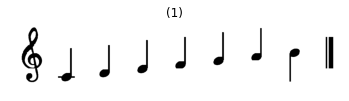

In [205]:
kernel = np.ones((3, 3), dtype=np.uint8)
new_img = cv.morphologyEx(no_staff_img, cv.MORPH_OPEN, kernel=kernel, iterations=2)
show_images([new_img])

In [57]:
bin_img.shape

(284, 1339)

## 1.3 （附加）取出音符，算hog特征，通过变换增加数据（或者也可以自己想办法增加数据），训练一个可以识别音符/谱号/终止符的分类器。

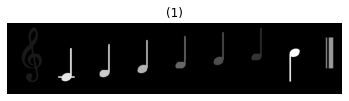

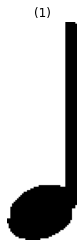

10


In [7]:
# 取出音符
from skimage.measure import label, regionprops
bw = 1-no_staff_img
label_img = label(bw)
show_images([label_img])

boundary = []
for region in regionprops(label_img):
    if region.area >= 100:
        boundary.append(region.bbox)

boundary = sorted(boundary, key=lambda b: b[1])

components = []
for bbox in boundary:
    minr, minc, maxr, maxc = bbox
    components.append(no_staff_img[minr:maxr, minc:maxc])

show_images([components[3]])
print(len(components))



In [ ]:
# TODO TODO TODO